In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=4)

# Automatically reload your external source code
%load_ext autoreload
%autoreload 2

In [6]:
from vgg_nets import VGG4Plus, VGG15, VGG15Plus, VGG15PlusPlus, VGG16Plus, VGG16PlusPlus
from vgg_nets import VGG8, VGG8OnOff, VGG8OnOffNoReduction, VGG15PlusPlusOffOn, VGG15PlusPlusOffOn
from datasets import get_dataset
import datasets
import time
from layers import MaxOnOffPool2D, MaxPool2D

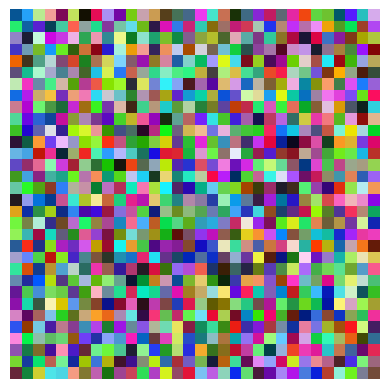

In [23]:
image_test = tf.random.uniform(shape=[1,32,32,3])
image_test, _ = datasets.standardize(image_test, image_test)
def plot_img(img):
    # Normalize the image values to the range [0, 1]
    img = (img - tf.reduce_min(img)) / (tf.reduce_max(img) - tf.reduce_min(img))

    # Convert tensor to a NumPy array and display it
    plt.imshow(img.numpy())
    plt.axis('off')  # Hide axis ticks and labels
    plt.show()
plot_img(image_test[0])

In [32]:
maxpoolOnOff = MaxOnOffPool2D("on_off_maxpool", pool_size=(2,2), strides = 2, prev_layer_or_block=None, padding='VALID')

In [33]:
maxpool = MaxPool2D("maxpool", pool_size=(2,2), strides = 2, prev_layer_or_block=None, padding='VALID')

(1, 16, 16, 3)
(1, 16, 16, 6)
(1, 16, 16, 3)
(1, 16, 16, 3)


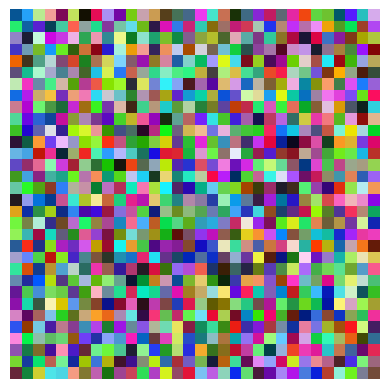

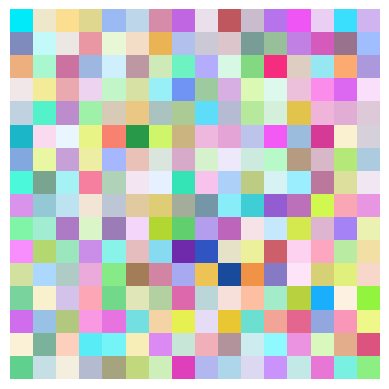

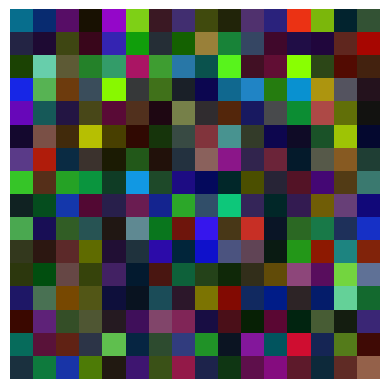

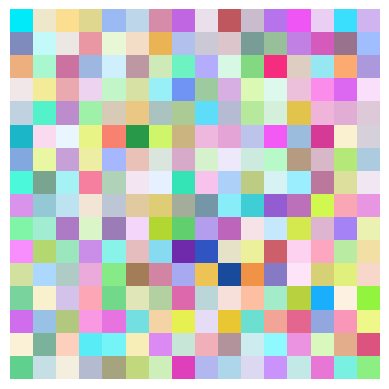

In [41]:
act_pool = maxpool(image_test)
print(act_pool.shape)
act_pool_on_off = maxpoolOnOff(image_test)
print(act_pool_on_off.shape)
act_pool_on_off_last = act_pool_on_off[:,:,:,-3:]
act_pool_on_off_first = act_pool_on_off[:,:,:,:3]
print(act_pool_on_off_last.shape)
print(act_pool_on_off_first.shape)
plot_img(image_test[0])
plot_img(act_pool[0])
plot_img(act_pool_on_off_last[0])
plot_img(act_pool_on_off_first[0])

## Importance?

act_pool shape: (1, 16, 16, 3)
act_pool_on_off shape: (1, 16, 16, 6)
On neurons shape: (1, 16, 16, 3)
Off neurons shape: (1, 16, 16, 3)


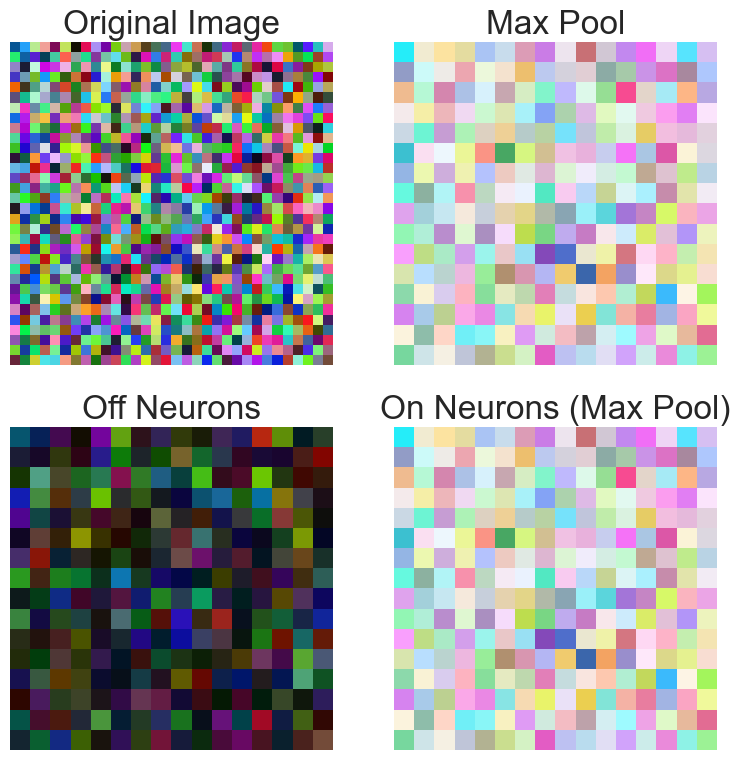

act_pool shape: (1, 16, 16, 3)
act_pool_on_off shape: (1, 16, 16, 6)
On neurons shape: (1, 16, 16, 3)
Off neurons shape: (1, 16, 16, 3)


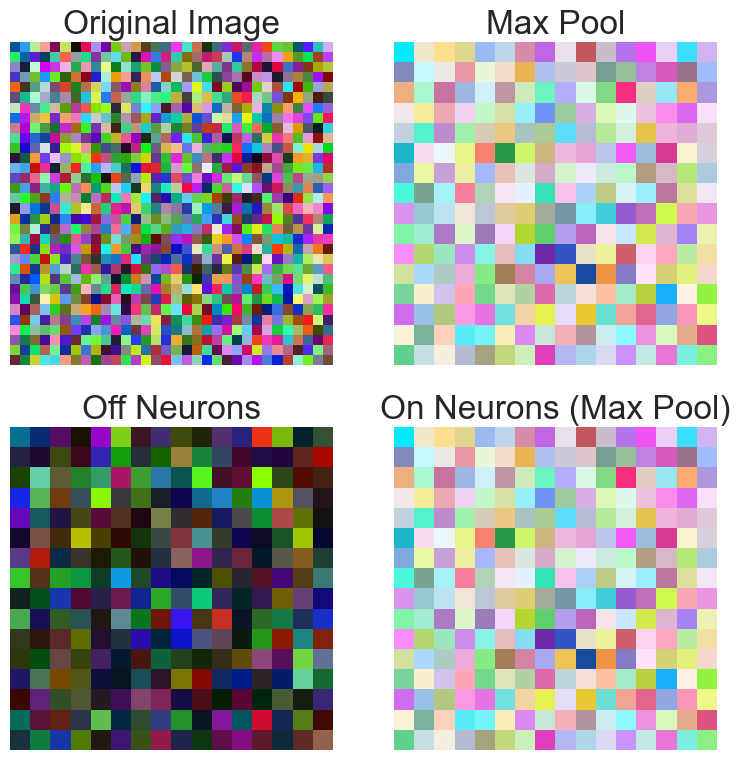

In [67]:
def plot_all_four_diff(image_test):
    maxpoolOnOff = MaxOnOffPool2D("on_off_maxpool", pool_size=(2,2), strides = 2, prev_layer_or_block=None, padding='VALID')
    maxpool = MaxPool2D("maxpool", pool_size=(2,2), strides = 2, prev_layer_or_block=None, padding='VALID')
    act_pool = maxpool(image_test)
    act_pool_on_off = maxpoolOnOff(image_test)
    act_pool_on_off_last = act_pool_on_off[:,:,:,-3:]
    act_pool_on_off_first = act_pool_on_off[:,:,:,:3]
    # plot_img(image_test[0])
    # plot_img(act_pool[0])
    # plot_img(act_pool_on_off_last[0])
    # plot_img(act_pool_on_off_first[0])

    def normalize_img(img):
        return (img - tf.reduce_min(img)) / (tf.reduce_max(img) - tf.reduce_min(img))
    # Print shapes for verification
    print("act_pool shape:", act_pool.shape)
    print("act_pool_on_off shape:", act_pool_on_off.shape)
    print("On neurons shape:", act_pool_on_off_first.shape)
    print("Off neurons shape:", act_pool_on_off_last.shape)

    # Create a 2x2 figure for visualization
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))

    # Top-left: Original image
    axs[0, 0].imshow(normalize_img(image_test[0]))
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis('off')

    # Top-right: Standard max pooled image
    axs[0, 1].imshow(normalize_img(act_pool[0]))
    axs[0, 1].set_title("Max Pool")
    axs[0, 1].axis('off')

    # Bottom-left: "Off" neurons (min pooling effect)
    axs[1, 0].imshow(normalize_img(act_pool_on_off_last[0]))
    axs[1, 0].set_title("Off Neurons")
    axs[1, 0].axis('off')

    # Bottom-right: "On" neurons (max pooling effect)
    axs[1, 1].imshow(normalize_img(act_pool_on_off_first[0]))
    axs[1, 1].set_title("On Neurons (Max Pool)")
    axs[1, 1].axis('off')

    plt.tight_layout()
    plt.show()
def plot_all_four_diff_normalized(image_test):
    # Create layer instances
    maxpoolOnOff = MaxOnOffPool2D("on_off_maxpool", pool_size=(2,2), strides=2, prev_layer_or_block=None, padding='VALID')
    maxpool = MaxPool2D("maxpool", pool_size=(2,2), strides=2, prev_layer_or_block=None, padding='VALID')
    
    # Apply pooling operations
    act_pool = maxpool(image_test)
    act_pool_on_off = maxpoolOnOff(image_test)
    
    # Split the on/off outputs (assuming original channels = 3)
    act_pool_on_off_first = act_pool_on_off[:, :, :, :3]  # "On" neurons
    act_pool_on_off_last  = act_pool_on_off[:, :, :, 3:]   # "Off" neurons
    
    # Collect images (squeezing out the batch dimension)
    imgs = [image_test[0], act_pool[0], act_pool_on_off_last[0], act_pool_on_off_first[0]]
    
    # Compute the global minimum and maximum across all images
    global_min = tf.reduce_min(tf.stack([tf.reduce_min(img) for img in imgs]))
    global_max = tf.reduce_max(tf.stack([tf.reduce_max(img) for img in imgs]))
    
    # Define a normalization function using the global min and max
    def normalize_img_with_global(img):
        return (img - global_min) / (global_max - global_min + 1e-8)  # add epsilon to avoid division by zero
    
    norm_image_test = normalize_img_with_global(image_test[0])
    norm_act_pool = normalize_img_with_global(act_pool[0])
    norm_act_pool_on_off_last = normalize_img_with_global(act_pool_on_off_last[0])
    norm_act_pool_on_off_first = normalize_img_with_global(act_pool_on_off_first[0])
    
    # Print shapes for verification
    print("act_pool shape:", act_pool.shape)
    print("act_pool_on_off shape:", act_pool_on_off.shape)
    print("On neurons shape:", act_pool_on_off_first.shape)
    print("Off neurons shape:", act_pool_on_off_last.shape)
    
    # Create a 2x2 figure for visualization
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    
    # Top-left: Original image
    axs[0, 0].imshow(norm_image_test.numpy())
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis('off')
    
    # Top-right: Standard max pooled image
    axs[0, 1].imshow(norm_act_pool.numpy())
    axs[0, 1].set_title("Max Pool")
    axs[0, 1].axis('off')
    
    # Bottom-left: "Off" neurons (min pooling effect)
    axs[1, 0].imshow(norm_act_pool_on_off_last.numpy())
    axs[1, 0].set_title("Off Neurons")
    axs[1, 0].axis('off')
    
    # Bottom-right: "On" neurons (max pooling effect)
    axs[1, 1].imshow(norm_act_pool_on_off_first.numpy())
    axs[1, 1].set_title("On Neurons (Max Pool)")
    axs[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()


plot_all_four_diff_normalized(image_test)

plot_all_four_diff(image_test)

### Importance


(1, 32, 32, 3)


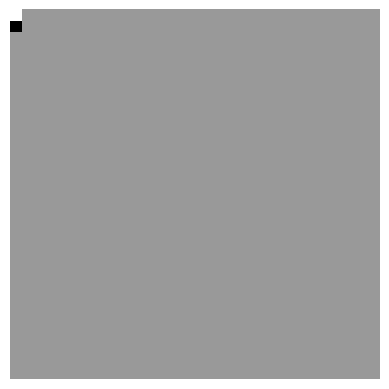

In [59]:

img_small_dark = tf.Variable(tf.ones(shape=(1,32,32,3)) * 0.6)
img_small_dark[0,0,0,:].assign(1)
img_small_dark[0,1,0,:].assign(0)
img_small_dark[0,1,0,:].assign(0)

print(img_small_dark.shape)
plot_img(img_small_dark[0])

(1, 32, 32, 3)


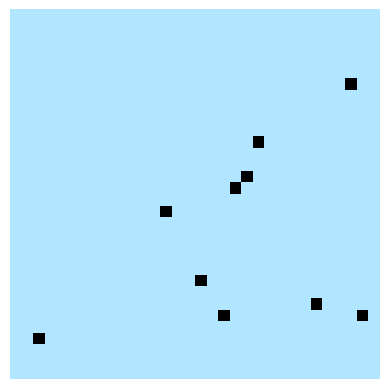

In [ ]:
# Create a light blue background.
# For a light blue color, we can use an RGB value like [0.7, 0.9, 1.0].
background_color = [0.7, 0.9, 1.0]
img_light_blue = tf.Variable(tf.ones(shape=(1, 32, 32, 3)) * background_color)

# Define number of black dots
num_dots = 10

# Get image dimensions (without the batch dimension)
height, width = 32, 32

# Randomly generate 10 (y, x) coordinates for the black dots
ys = np.random.randint(0, height, num_dots)
xs = np.random.randint(0, width, num_dots)

# Place black dots ([0, 0, 0]) at the randomly selected coordinates.
# Since the variable has a batch dimension of 1, we index it as [0, y, x, :]
for y, x in zip(ys, xs):
    img_light_blue[0, y, x, :].assign([0.0, 0.0, 0.0])

# Verify the shape and plot the image using your plot_img function.
print(img_light_blue.shape)
plot_img(img_light_blue[0])

act_pool shape: (1, 16, 16, 3)
act_pool_on_off shape: (1, 16, 16, 6)
On neurons shape: (1, 16, 16, 3)
Off neurons shape: (1, 16, 16, 3)


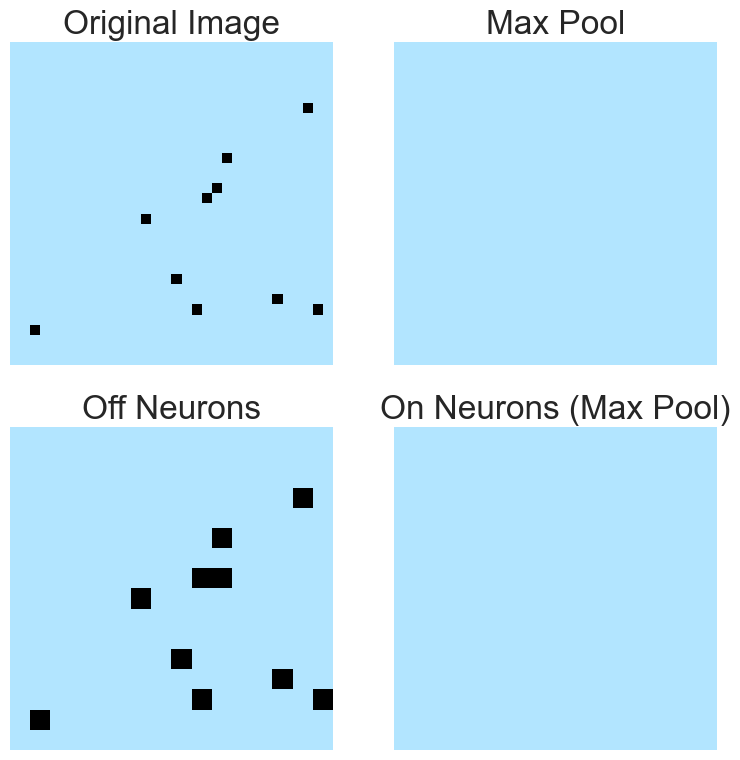

In [68]:
plot_all_four_diff_normalized(img_light_blue)

(1, 32, 32, 3)


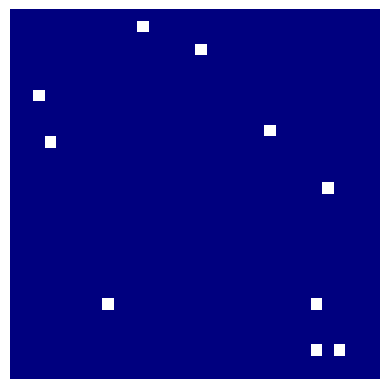

In [69]:
import tensorflow as tf
import numpy as np

# Create a dark blue background.
# For a dark blue color, we can use an RGB value like [0.0, 0.0, 0.5].
background_color = [0.0, 0.0, 0.5]
img_dark_blue = tf.Variable(tf.ones(shape=(1, 32, 32, 3)) * background_color)

# Define number of white spots.
num_spots = 10

# Get image dimensions (without the batch dimension)
height, width = 32, 32

# Randomly generate 10 (y, x) coordinates for the white spots
ys = np.random.randint(0, height, num_spots)
xs = np.random.randint(0, width, num_spots)

# Place white spots ([1.0, 1.0, 1.0]) at the randomly selected coordinates.
# Since the variable has a batch dimension of 1, we index it as [0, y, x, :].
for y, x in zip(ys, xs):
    img_dark_blue[0, y, x, :].assign([1.0, 1.0, 1.0])

# Verify the shape and plot the image using your plot_img function.
print(img_dark_blue.shape)
plot_img(img_dark_blue[0])


act_pool shape: (1, 16, 16, 3)
act_pool_on_off shape: (1, 16, 16, 6)
On neurons shape: (1, 16, 16, 3)
Off neurons shape: (1, 16, 16, 3)


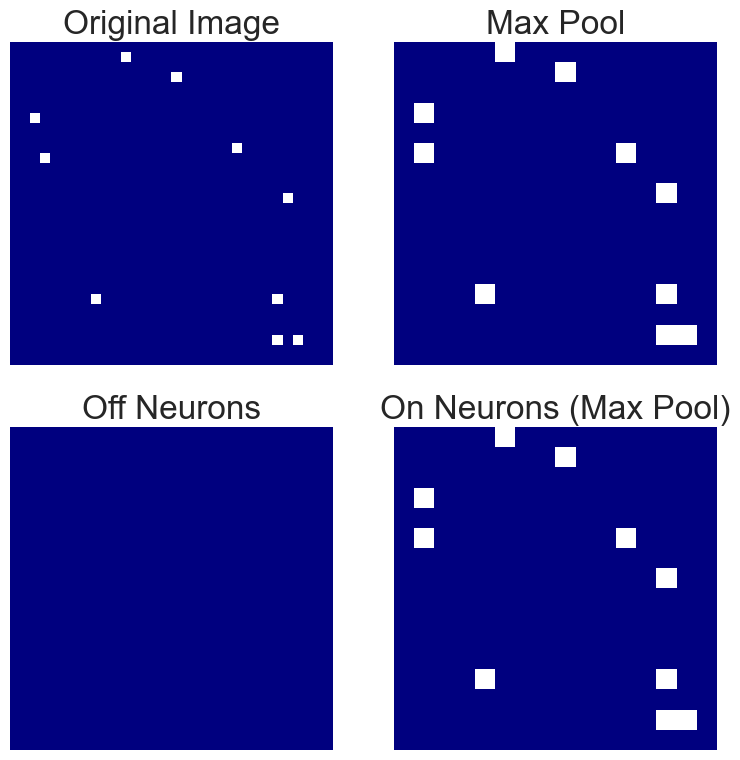

In [70]:
plot_all_four_diff_normalized(img_dark_blue)